## Imports and Setup

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json

# Qiskit
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_aer.noise as noise
from mitiq import zne

# Our clean utilities
from utils.quantum_execution import (
    calibrate_mthree
)
from utils.experiment_runners import (
    run_baseline_experiment, run_pcs_experiment, 
    run_ideal_experiment, extrapolate_pcs_data,
    collect_zne_data, extrapolate_zne_data
)
from utils.circuit_generation import generate_rand_mirror_cliff, ghz_mirror_circ
from utils.layout_finder import (
    find_best_payload_layout, build_pcs_config
)

print("✅ All imports successful!")

✅ All imports successful!


## Configuration

In [2]:
# Experiment parameters
USE_REAL_HARDWARE = False
BACKEND_NAME = "ibm_kingston"

num_qubits = 4
max_num_checks = 3
circ_depth = 5
num_circuits = 5

barriers = True

# Shot allocation
pcs_shots_per_check = 20_000
total_shots = pcs_shots_per_check * max_num_checks
baseline_shots = pcs_shots_per_check

# Error mitigation settings
enable_mthree = True
enable_twirling = True

# Observable
pauli_string = "Z" * num_qubits

# PCE/ZNE methods
pce_methods = ["linear", "exponential"]
zne_methods = ["linear", "richardson"]
scale_factors = [1, 3, 5]

print(f"Configuration:")
print(f"  Backend: {BACKEND_NAME} ({'real' if USE_REAL_HARDWARE else 'simulated'})")
print(f"  Circuits: {num_circuits} × {num_qubits}q depth-{circ_depth}")
print(f"  Shots: {total_shots} total, {pcs_shots_per_check} per PCS check")
print(f"  Observable: {pauli_string}")

Configuration:
  Backend: ibm_brisbane (simulated)
  Circuits: 5 × 4q depth-30
  Shots: 150000 total, 50000 per PCS check
  Observable: ZZZZ


## Backend Setup

In [3]:
from qiskit_ibm_runtime.fake_provider import *
from qiskit.visualization import plot_error_map

# Initialize backend
service = QiskitRuntimeService()

if USE_REAL_HARDWARE:
    backend = service.backend(BACKEND_NAME)
    print(f"Using real hardware: {backend.name}")
else:
    if BACKEND_NAME == 'ibm_fez':
        backend = FakeFez()

    elif BACKEND_NAME == 'ibm_brisbane':
        backend = FakeBrisbane()

    else:
        backend = None
        print(f"Warning: No fake backend found for '{BACKEND_NAME}'")
    
    
# plot_error_map(backend, figsize=(12, 10))

## Generate Test Circuits

Generating random mirrored Clifford circuits...
Generated 5 circuits

Example circuit:


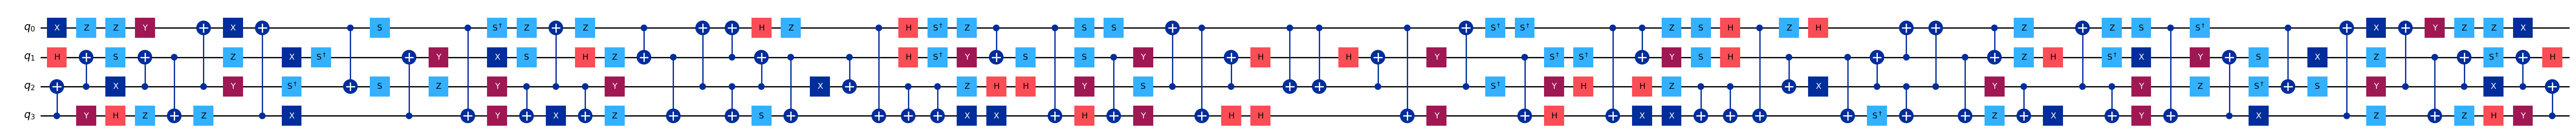

In [4]:
# Generate random mirrored Clifford circuits
print("Generating random mirrored Clifford circuits...")
circuits = [generate_rand_mirror_cliff(num_qubits, circ_depth) for _ in range(num_circuits)]

print(f"Generated {len(circuits)} circuits")

# Show example circuit
print("\nExample circuit:")
display(circuits[0].draw('mpl', fold=-1))

## Find Optimal Layouts

In [5]:
# Find optimal payload layouts for all circuits
print("Finding optimal payload layouts...")
circuit_configs = []

for circ_idx, circuit in enumerate(circuits):
    print(f"\nCircuit {circ_idx + 1}/{num_circuits}:")
    
    # Find the best payload layout that can support our max number of checks
    try:
        payload_layout = find_best_payload_layout(circuit, backend, max_num_checks, verbose=True)
        print(f"  ✅ Payload layout: {payload_layout}")
        
        circuit_configs.append({
            'circuit': circuit,
            'payload_layout': payload_layout
        })
        
    except RuntimeError as e:
        raise RuntimeError(f"❌ Circuit {circ_idx + 1}: {e}")

print(f"\n✅ Found layouts for all {len(circuits)} circuits")

Finding optimal payload layouts...

Circuit 1/5:
testing layout:  [30, 17, 12, 11]
connectivity graph =  {0: {1, 14}, 1: {0, 2}, 2: {1, 3}, 3: {2, 4}, 4: {3, 5, 15}, 5: {4, 6}, 6: {5, 7}, 7: {8, 6}, 8: {16, 9, 7}, 9: {8, 10}, 10: {9, 11}, 11: {10, 12}, 12: {17, 11, 13}, 13: {12}, 14: {0, 18}, 15: {4, 22}, 16: {8, 26}, 17: {12, 30}, 18: {19, 14}, 19: {18, 20}, 20: {33, 19, 21}, 21: {20, 22}, 22: {23, 21, 15}, 23: {24, 22}, 24: {25, 34, 23}, 25: {24, 26}, 26: {16, 25, 27}, 27: {26, 28}, 28: {35, 27, 29}, 29: {28, 30}, 30: {17, 29, 31}, 31: {32, 30}, 32: {36, 31}, 33: {20, 39}, 34: {24, 43}, 35: {28, 47}, 36: {32, 51}, 37: {52, 38}, 38: {37, 39}, 39: {40, 33, 38}, 40: {41, 39}, 41: {40, 42, 53}, 42: {41, 43}, 43: {34, 42, 44}, 44: {43, 45}, 45: {54, 44, 46}, 46: {45, 47}, 47: {48, 35, 46}, 48: {49, 47}, 49: {48, 50, 55}, 50: {49, 51}, 51: {50, 36}, 52: {56, 37}, 53: {41, 60}, 54: {64, 45}, 55: {49, 68}, 56: {57, 52}, 57: {56, 58}, 58: {57, 59, 71}, 59: {58, 60}, 60: {61, 59, 53}, 61: {60,

In [6]:
circuit_configs[0]["payload_layout"]

[30, 17, 12, 11]

## Calibrate Readout Mitigation

In [7]:
# Calculate all qubits that will be used for mthree calibration
all_qubits_used = set()

for config in circuit_configs:
    payload_layout = config['payload_layout']
    all_qubits_used.update(payload_layout)
    
    # Add potential ancilla positions for max checks
    try:
        from utils.layout_finder import get_check_assignments
        assignments = get_check_assignments(payload_layout, backend, max_num_checks)
        ancilla_positions = [pair[1] for pair in assignments]
        all_qubits_used.update(ancilla_positions)
    except Exception as e:
        print(f"Warning: Could not determine ancilla positions: {e}")

print(f"Total qubits to be used: {len(all_qubits_used)} - {sorted(all_qubits_used)}")

# Calibrate mthree if using real hardware
mthree_mit = None

if enable_mthree:
    print(f"Calibrating mthree for {len(all_qubits_used)} qubits...")
    mthree_mit = calibrate_mthree(backend, list(all_qubits_used))
    print("✅ mthree calibration complete")
else:
    print("mthree disabled")

Total qubits to be used: 7 - [10, 11, 12, 13, 17, 29, 30]
Calibrating mthree for 7 qubits...
✅ mthree calibration complete


## Main Experiment Loop

Results will be saved to: results/sim_fake_brisbane/pce_vs_zne_4q_30d.jsonl


CIRCUIT 1/5
Payload Layout: [30, 17, 12, 11]
payload circuit:


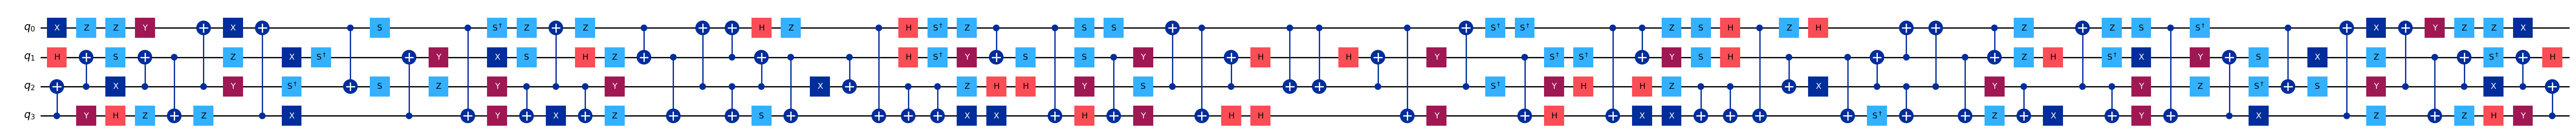


1. Computing ideal expectation value...
   Ideal: 1.000000

2. Running baseline experiment...
   Baseline: 0.205720

3. Running PCS experiments...
   PCS with 1 checks...


/opt/anaconda3/envs/qiskit_cloud_test/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'twirling': {'enable_gates': True, 'enable_measure': False, 'shots_per_randomization': 'auto', 'strategy': 'active-circuit'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


      Score: 0.516012, Post-selection: 72.57%
   PCS with 2 checks...
      Score: 0.714270, Post-selection: 55.59%
   PCS with 3 checks...
      Score: 0.784277, Post-selection: 48.32%

4. Applying PCE extrapolation...


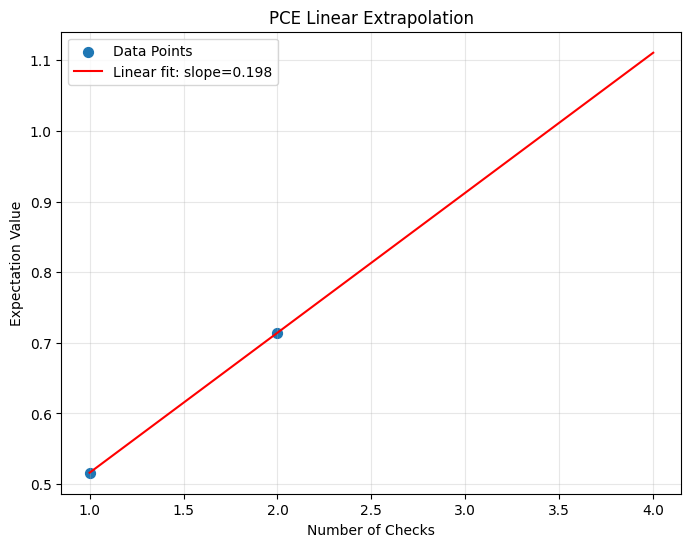

   pce_linear_2pts: 1.110784


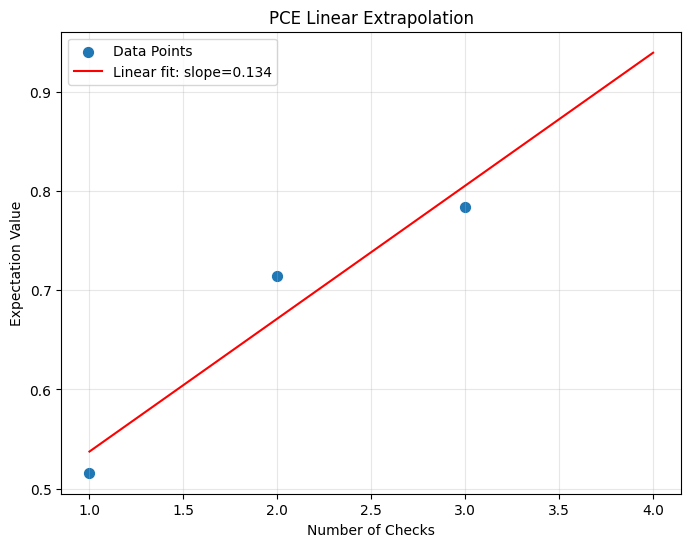

   pce_linear_3pts: 0.939784


/Users/quinn.langfitt/git/PCS_ZNE/utils/error_mitigation.py:192: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


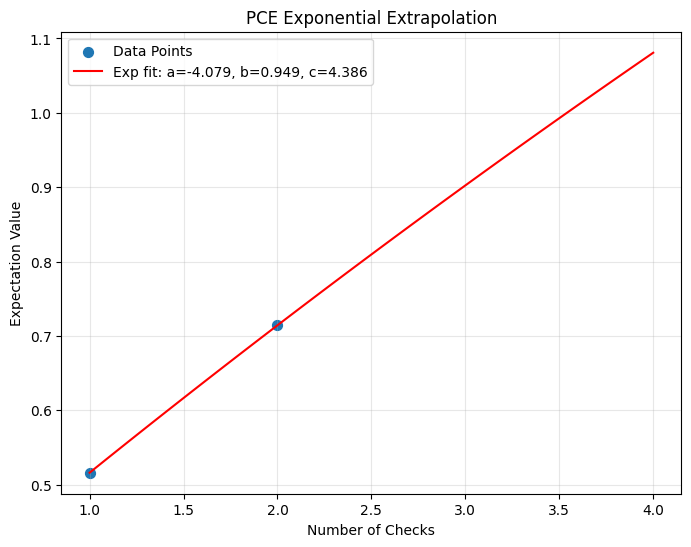

   pce_exponential_2pts: 1.080832


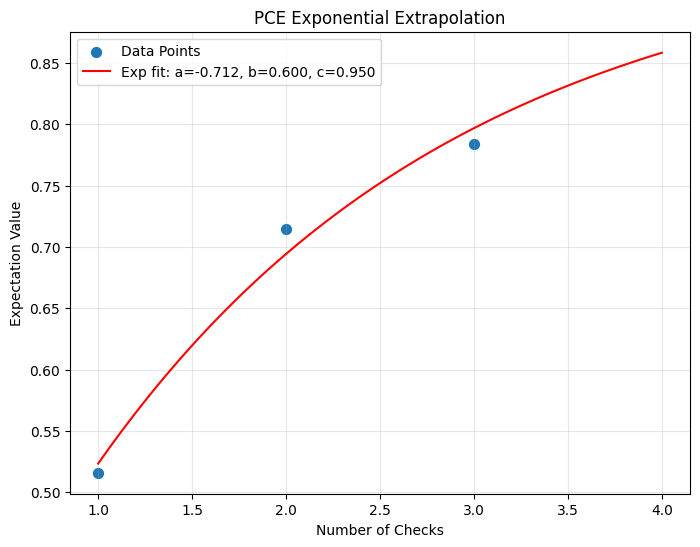

   pce_exponential_3pts: 0.858247

5. Collecting ZNE data...
zne shots per scale =  50000
  Scale factor 1...
    Expectation: 0.377065
  Scale factor 3...
    Expectation: 0.043435
  Scale factor 5...
    Expectation: 0.004438

6. Applying ZNE extrapolation methods...


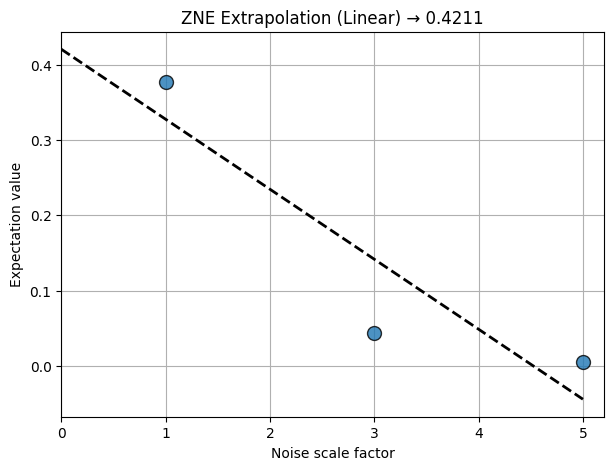

   ZNE linear: 0.421116


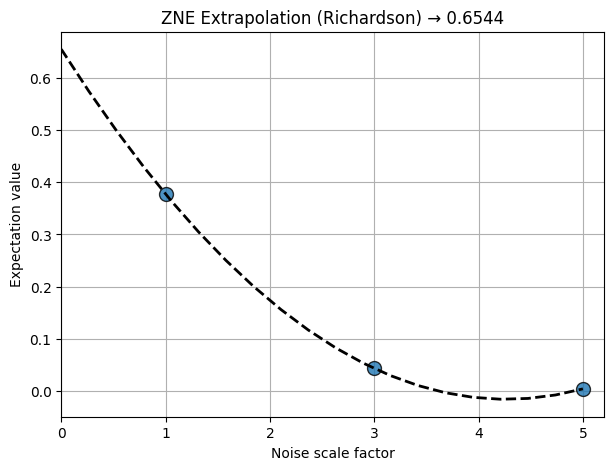

   ZNE richardson: 0.654368

✅ Circuit 1 complete and saved

CIRCUIT 2/5
Payload Layout: [30, 17, 12, 11]
payload circuit:


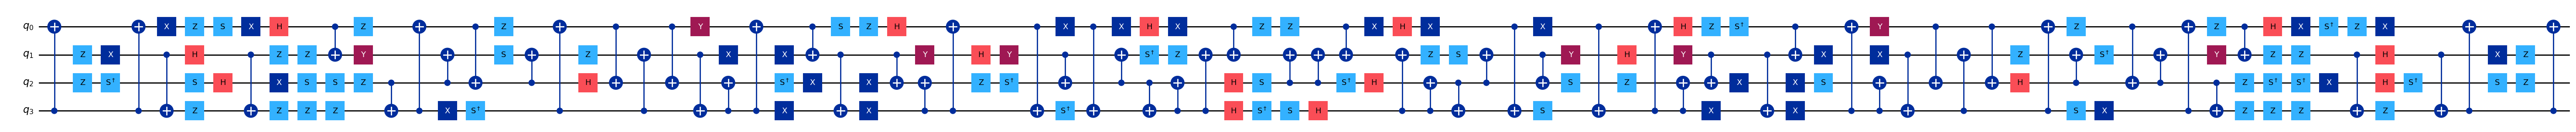


1. Computing ideal expectation value...
   Ideal: 1.000000

2. Running baseline experiment...
   Baseline: 0.194000

3. Running PCS experiments...
   PCS with 1 checks...


/opt/anaconda3/envs/qiskit_cloud_test/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'twirling': {'enable_gates': True, 'enable_measure': False, 'shots_per_randomization': 'auto', 'strategy': 'active-circuit'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


      Score: 0.518283, Post-selection: 69.36%
   PCS with 2 checks...
      Score: 0.652505, Post-selection: 56.14%
   PCS with 3 checks...
      Score: 0.808929, Post-selection: 46.45%

4. Applying PCE extrapolation...


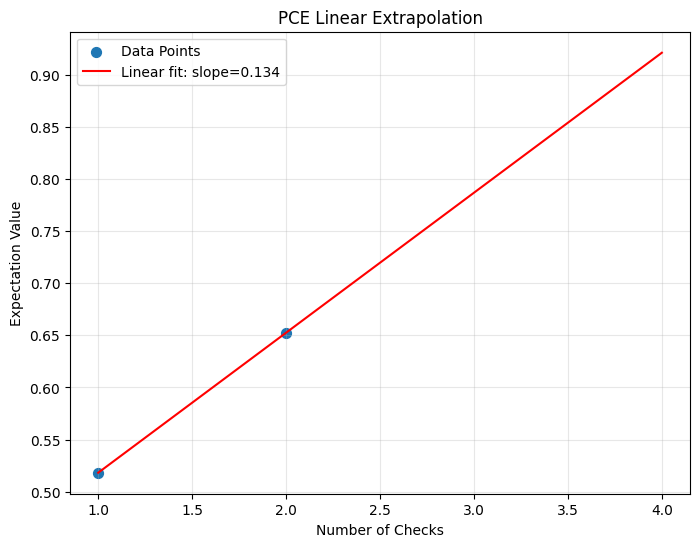

   pce_linear_2pts: 0.920950


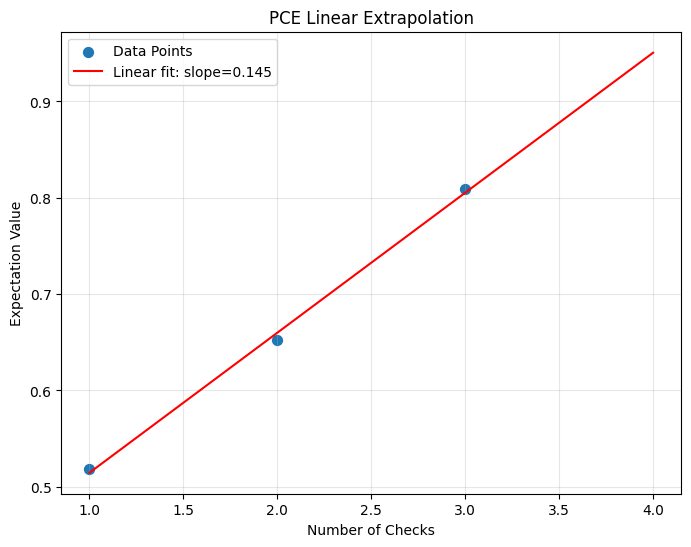

   pce_linear_3pts: 0.950552


/Users/quinn.langfitt/git/PCS_ZNE/utils/error_mitigation.py:192: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


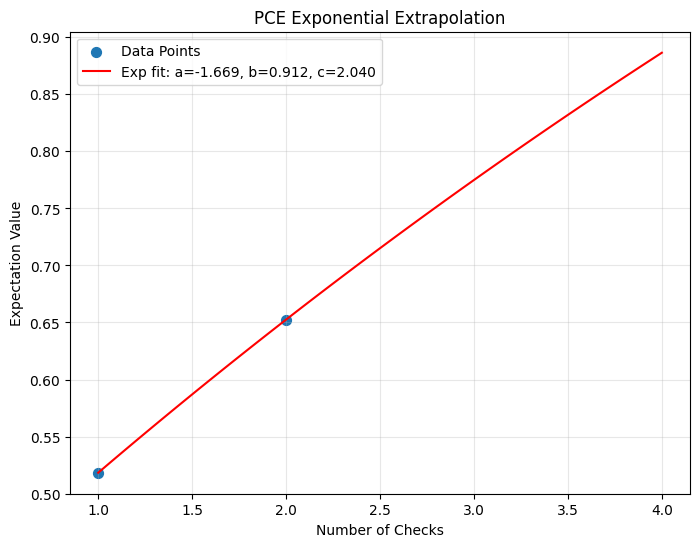

   pce_exponential_2pts: 0.886472


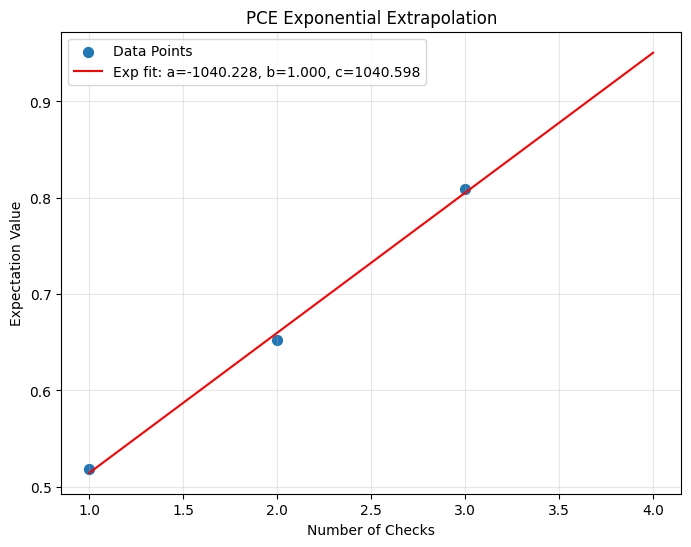

   pce_exponential_3pts: 0.950518

5. Collecting ZNE data...
zne shots per scale =  50000
  Scale factor 1...
    Expectation: 0.360881
  Scale factor 3...
    Expectation: 0.044260
  Scale factor 5...
    Expectation: 0.011500

6. Applying ZNE extrapolation methods...


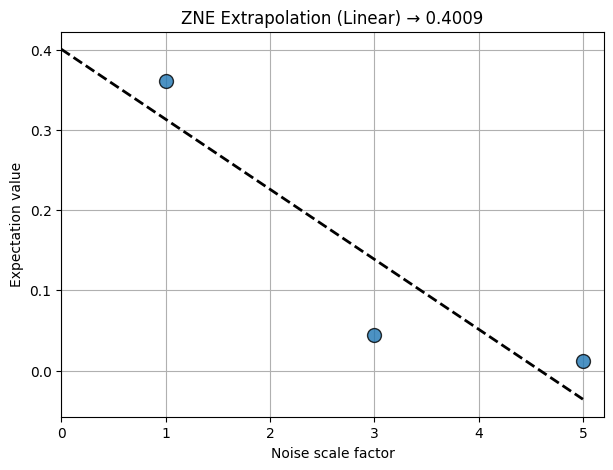

   ZNE linear: 0.400916


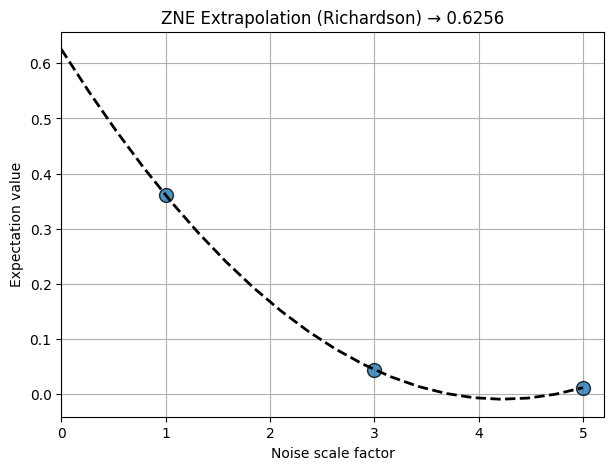

   ZNE richardson: 0.625639

✅ Circuit 2 complete and saved

CIRCUIT 3/5
Payload Layout: [30, 17, 12, 11]
payload circuit:


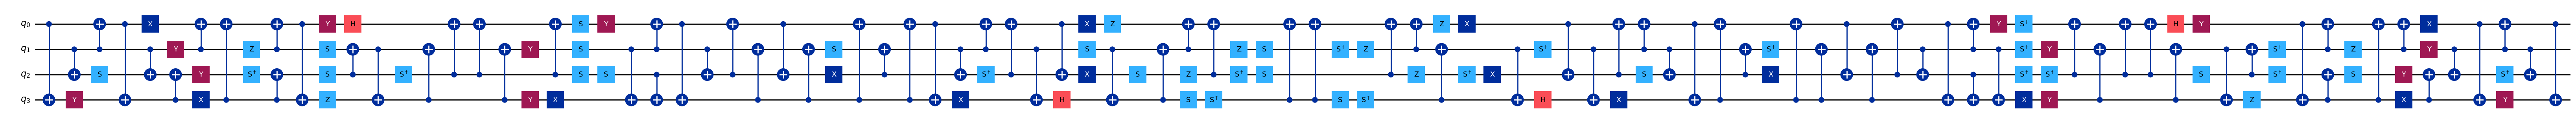


1. Computing ideal expectation value...
   Ideal: 1.000000

2. Running baseline experiment...
   Baseline: 0.238280

3. Running PCS experiments...
   PCS with 1 checks...


/opt/anaconda3/envs/qiskit_cloud_test/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'twirling': {'enable_gates': True, 'enable_measure': False, 'shots_per_randomization': 'auto', 'strategy': 'active-circuit'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


      Score: 0.565318, Post-selection: 68.53%
   PCS with 2 checks...
      Score: 0.604060, Post-selection: 56.48%
   PCS with 3 checks...
      Score: 1.129585, Post-selection: 40.70%

4. Applying PCE extrapolation...


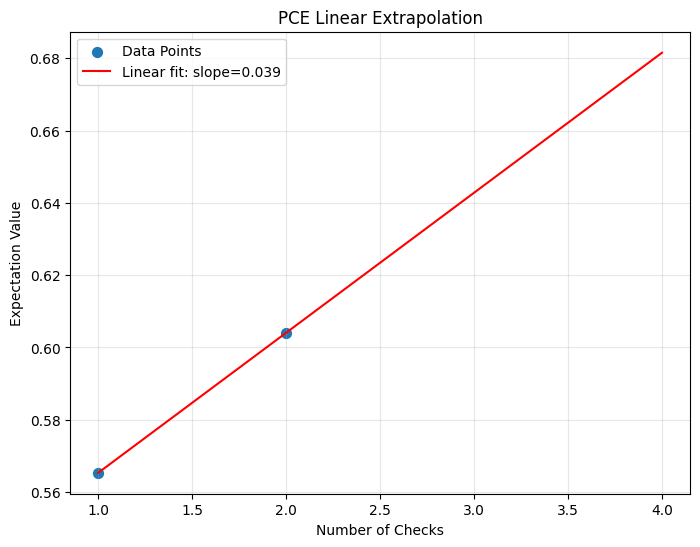

   pce_linear_2pts: 0.681542


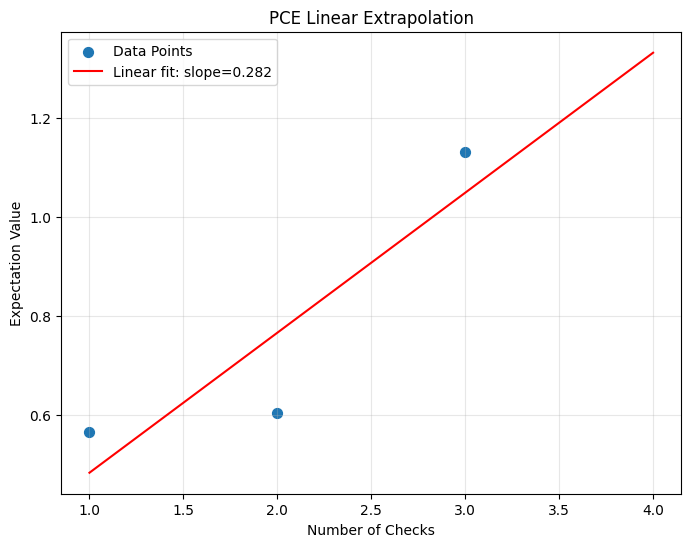

   pce_linear_3pts: 1.330588


/Users/quinn.langfitt/git/PCS_ZNE/utils/error_mitigation.py:192: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


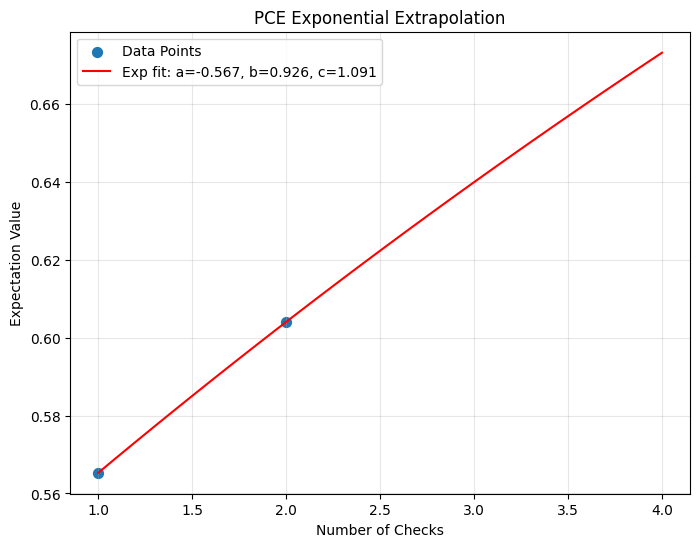

   pce_exponential_2pts: 0.673179


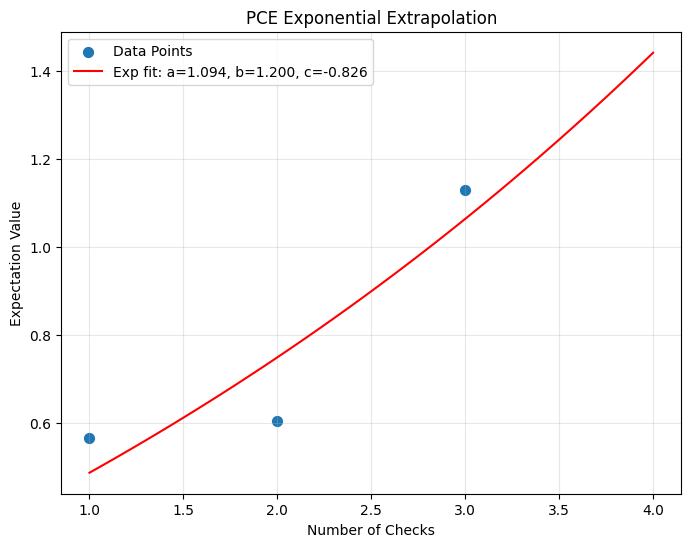

   pce_exponential_3pts: 1.441736

5. Collecting ZNE data...
zne shots per scale =  50000
  Scale factor 1...
    Expectation: 0.393095
  Scale factor 3...
    Expectation: 0.075238
  Scale factor 5...
    Expectation: -0.011097

6. Applying ZNE extrapolation methods...


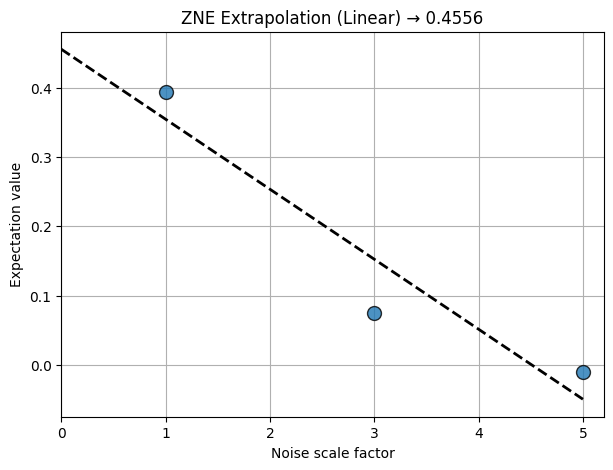

   ZNE linear: 0.455556


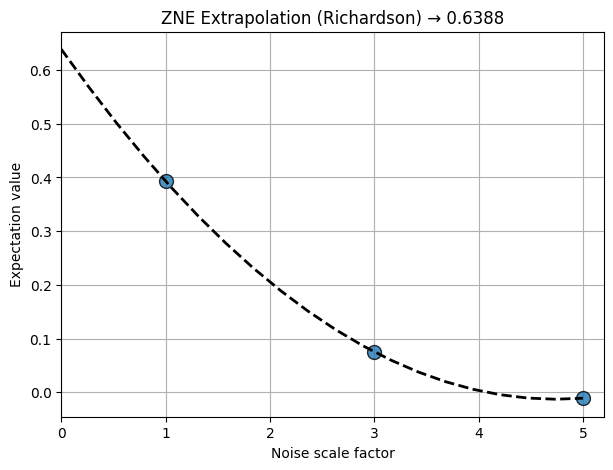

   ZNE richardson: 0.638844

✅ Circuit 3 complete and saved

CIRCUIT 4/5
Payload Layout: [30, 17, 12, 11]
payload circuit:


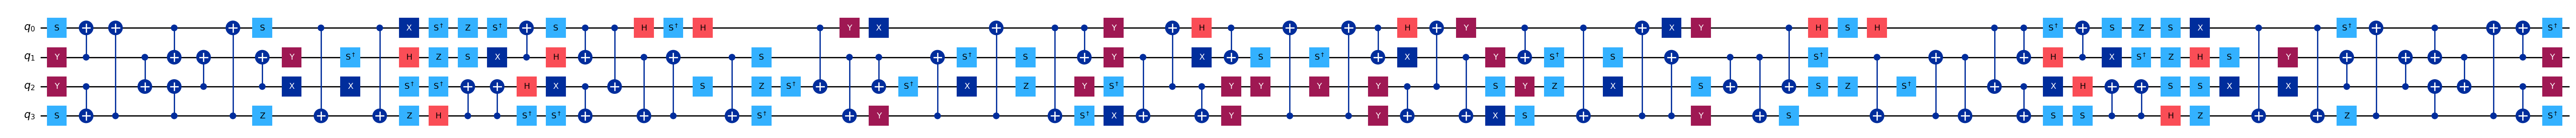


1. Computing ideal expectation value...
   Ideal: 1.000000

2. Running baseline experiment...
   Baseline: 0.273680

3. Running PCS experiments...
   PCS with 1 checks...


/opt/anaconda3/envs/qiskit_cloud_test/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'twirling': {'enable_gates': True, 'enable_measure': False, 'shots_per_randomization': 'auto', 'strategy': 'active-circuit'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


      Score: 0.669541, Post-selection: 71.89%
   PCS with 2 checks...
      Score: 0.754211, Post-selection: 58.18%
   PCS with 3 checks...
      Score: 0.905013, Post-selection: 52.20%

4. Applying PCE extrapolation...


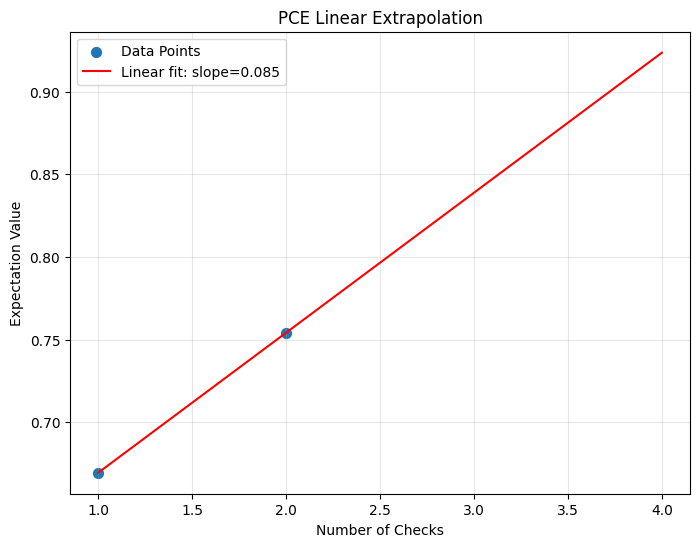

   pce_linear_2pts: 0.923552


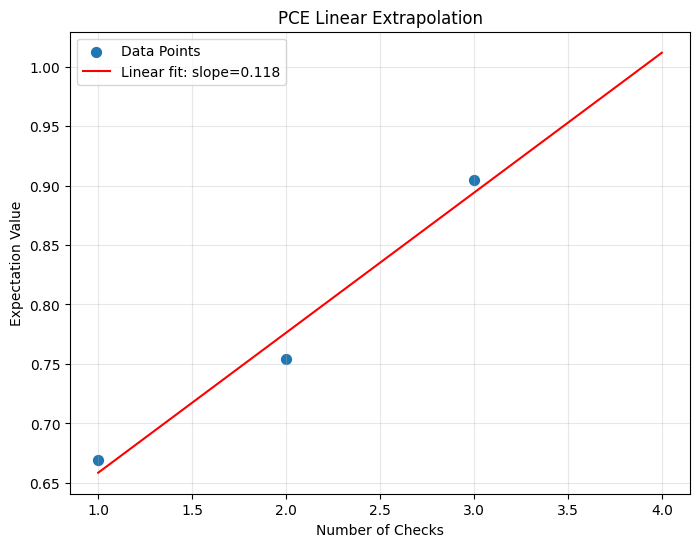

   pce_linear_3pts: 1.011728


/Users/quinn.langfitt/git/PCS_ZNE/utils/error_mitigation.py:192: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


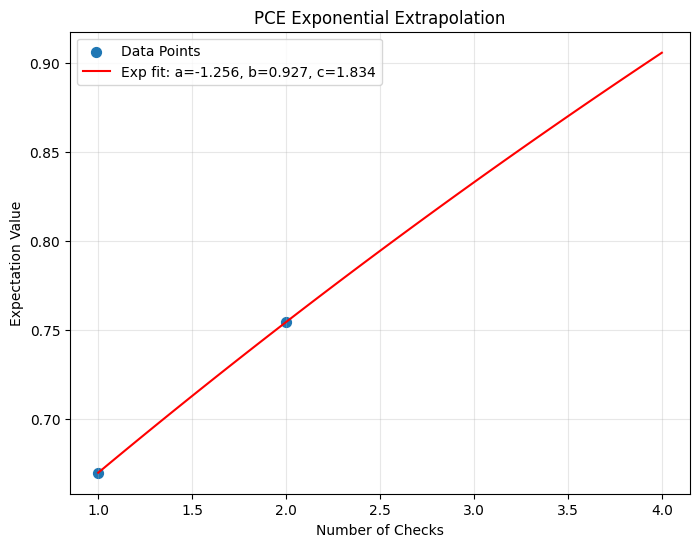

   pce_exponential_2pts: 0.905536


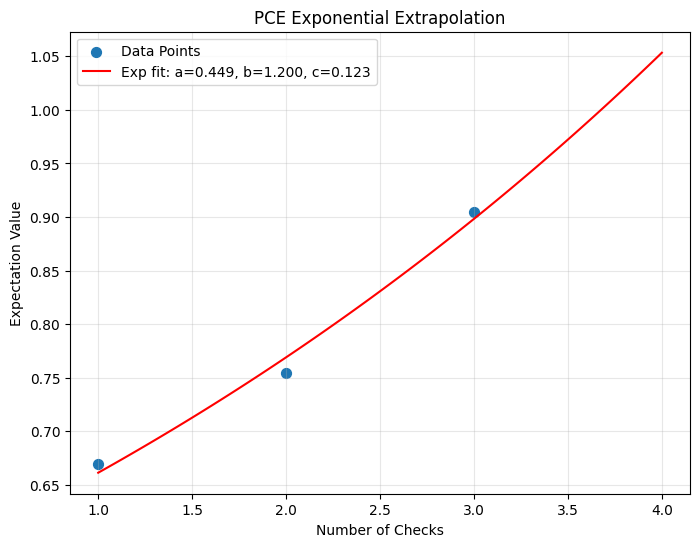

   pce_exponential_3pts: 1.053267

5. Collecting ZNE data...
zne shots per scale =  50000
  Scale factor 1...
    Expectation: 0.504754
  Scale factor 3...
    Expectation: 0.100710
  Scale factor 5...
    Expectation: 0.024461

6. Applying ZNE extrapolation methods...


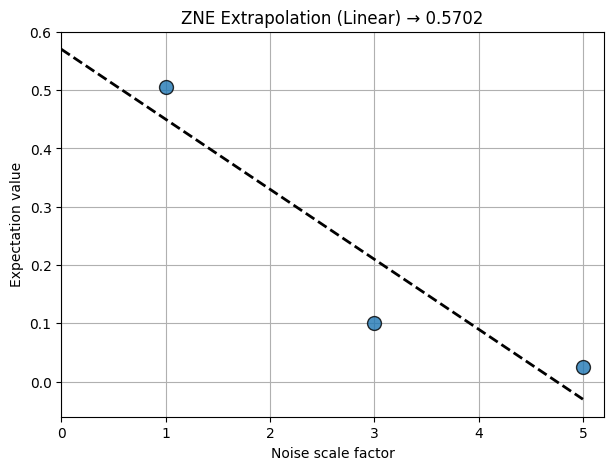

   ZNE linear: 0.570194


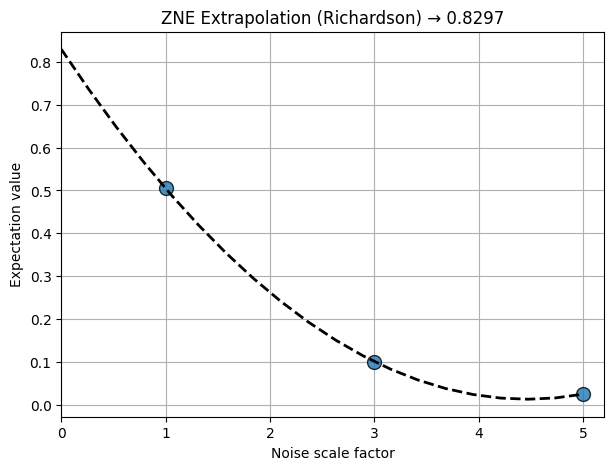

   ZNE richardson: 0.829698

✅ Circuit 4 complete and saved

CIRCUIT 5/5
Payload Layout: [30, 17, 12, 11]
payload circuit:


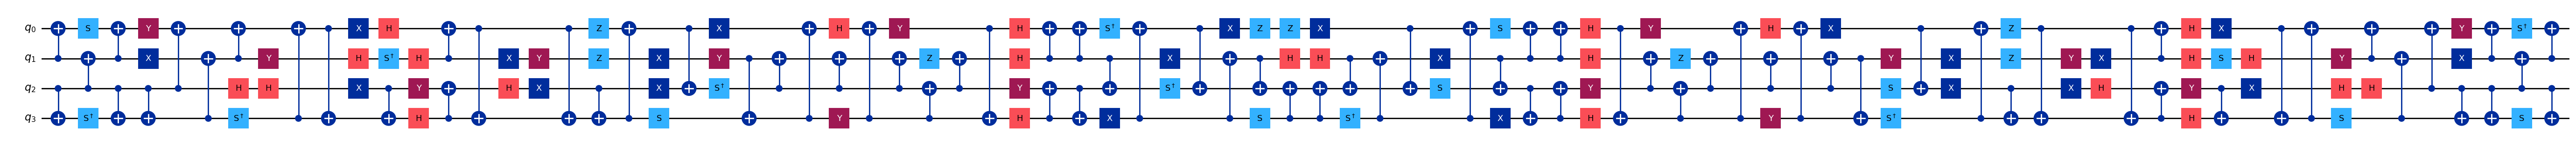


1. Computing ideal expectation value...
   Ideal: 1.000000

2. Running baseline experiment...
   Baseline: 0.208120

3. Running PCS experiments...
   PCS with 1 checks...


/opt/anaconda3/envs/qiskit_cloud_test/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'twirling': {'enable_gates': True, 'enable_measure': False, 'shots_per_randomization': 'auto', 'strategy': 'active-circuit'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


      Score: 0.527988, Post-selection: 69.76%
   PCS with 2 checks...
      Score: 0.640007, Post-selection: 56.11%
   PCS with 3 checks...
      Score: 0.774355, Post-selection: 49.21%

4. Applying PCE extrapolation...


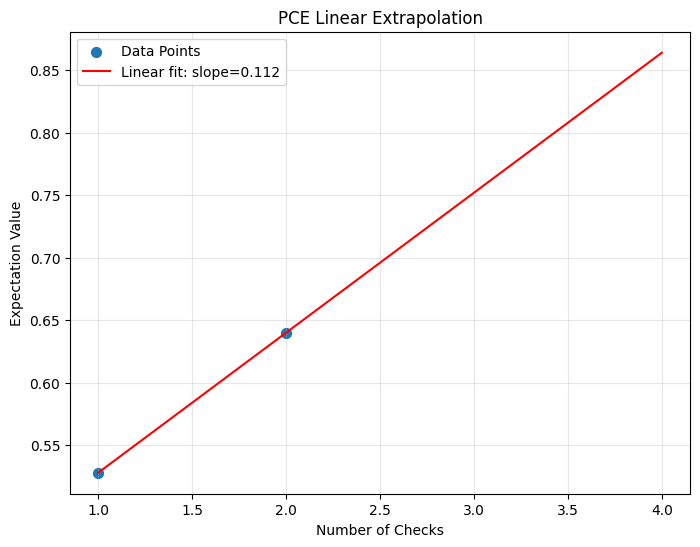

   pce_linear_2pts: 0.864044


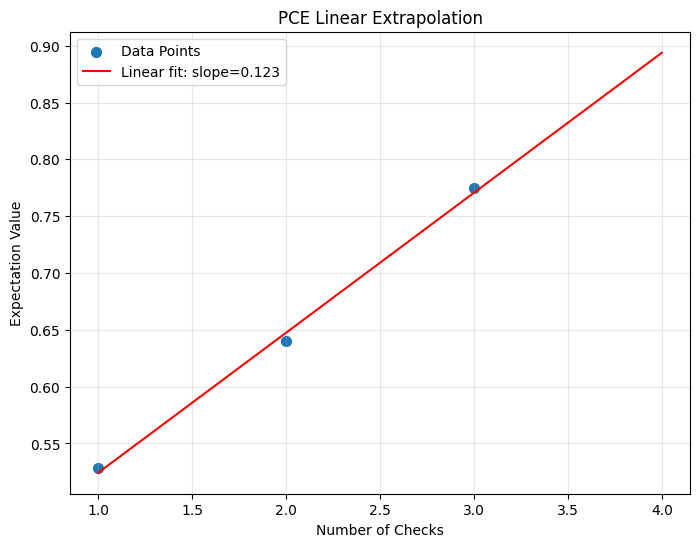

   pce_linear_3pts: 0.893817


/Users/quinn.langfitt/git/PCS_ZNE/utils/error_mitigation.py:192: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


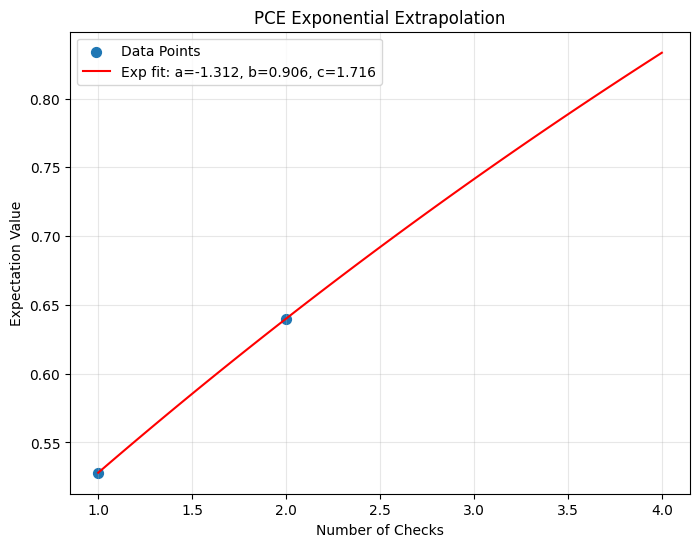

   pce_exponential_2pts: 0.833352


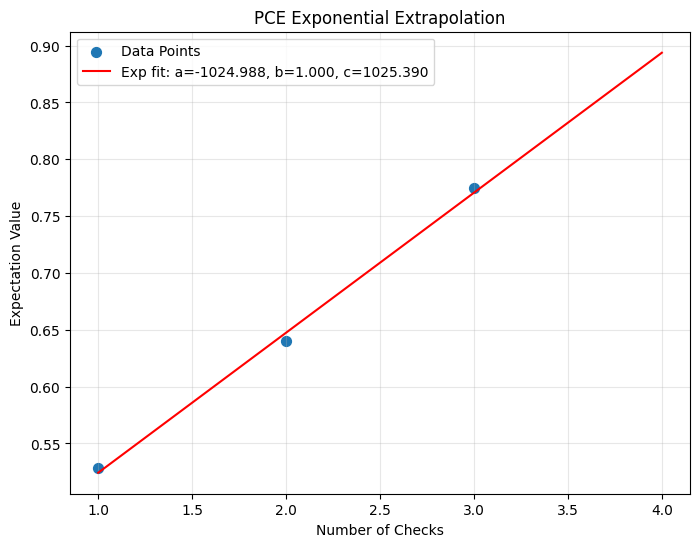

   pce_exponential_3pts: 0.893791

5. Collecting ZNE data...
zne shots per scale =  50000
  Scale factor 1...
    Expectation: 0.368434
  Scale factor 3...
    Expectation: 0.052600
  Scale factor 5...
    Expectation: 0.008105

6. Applying ZNE extrapolation methods...


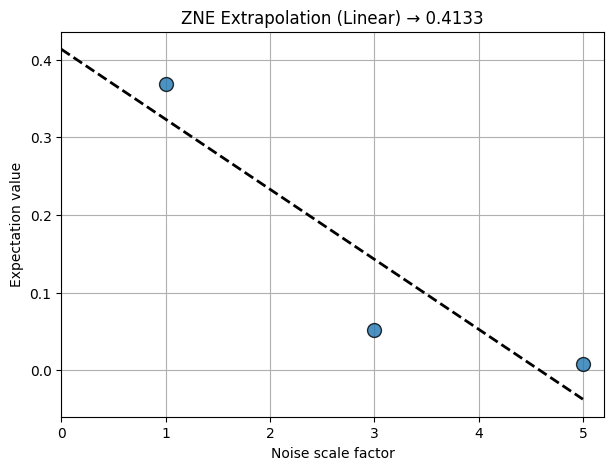

   ZNE linear: 0.413293


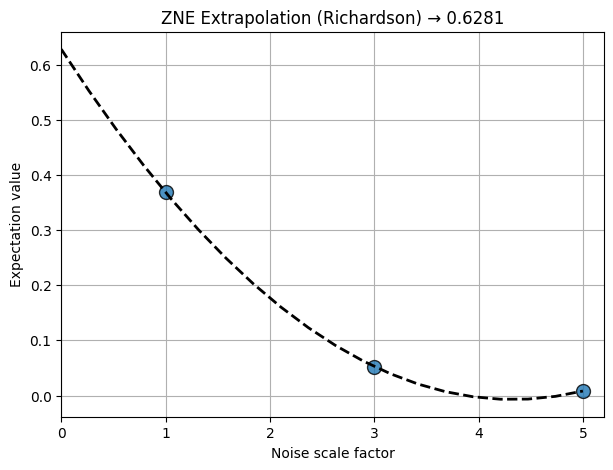

   ZNE richardson: 0.628103

✅ Circuit 5 complete and saved

🎉 ALL EXPERIMENTS COMPLETE!
Results saved to: results/sim_fake_brisbane/pce_vs_zne_4q_30d.jsonl


In [8]:
# Results storage
all_results = []

# Create save directory
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"results/{'real' if USE_REAL_HARDWARE else 'sim'}_{backend.backend_name}"
os.makedirs(results_dir, exist_ok=True)
results_file = f"{results_dir}/pce_vs_zne_{num_qubits}q_{circ_depth}d.jsonl"

print(f"Results will be saved to: {results_file}\n")

for circuit_idx, circuit in enumerate(circuits):
    print(f"\n{'='*60}")
    print(f"CIRCUIT {circuit_idx + 1}/{len(circuits)}")
    print(f"{'='*60}")
    
    # Get pre-computed payload layout
    config = circuit_configs[circuit_idx]
    payload_layout = config['payload_layout']
    print(f"Payload Layout: {payload_layout}")
    print("payload circuit:")
    display(circuit.draw("mpl", fold=-1))
    
    # 1. IDEAL EXPECTATION VALUE
    print("\n1. Computing ideal expectation value...")
    ideal_expectation = run_ideal_experiment(circuit=circuit, pauli_string=pauli_string, shots=baseline_shots)
    print(f"   Ideal: {ideal_expectation:.6f}")
    
    # 2. BASELINE EXPERIMENT
    print("\n2. Running baseline experiment...")
    baseline_exp, baseline_meta = run_baseline_experiment(
        circuit, backend, pauli_string, baseline_shots,
        layout=payload_layout, twirling=False, mthree=None
    )
    print(f"   Baseline: {baseline_exp:.6f}")
    
    # 3. PCS EXPERIMENTS - build configurations on-demand
    print("\n3. Running PCS experiments...")
    pcs_results = []
    pcs_metadata = []
    
    for num_checks in range(1, max_num_checks + 1):
        print(f"   PCS with {num_checks} checks...")
        
        # Build PCS configuration on-demand
        pcs_config = build_pcs_config(circuit, payload_layout, num_checks, backend)
        
        # Run PCS experiment
        signs = ["+1"] * num_checks  # Mirror circuits have positive checks
        pcs_exp, pcs_meta = run_pcs_experiment(
            pcs_config['circuit'], backend, pauli_string, pcs_shots_per_check,
            num_checks, signs, layout=pcs_config['layout'],
            twirling=enable_twirling, mthree=mthree_mit
        )
        
        pcs_results.append(pcs_exp)
        pcs_metadata.append(pcs_meta)
        
        print(f"      Score: {pcs_exp:.6f}, Post-selection: {pcs_meta['post_selection_rate']:.2%}")
    
    # 4. PCE EXTRAPOLATION
    print("\n4. Applying PCE extrapolation...")
    pce_results = {}
    
    if max_num_checks >= 2:
        for method in pce_methods:
            for num_fit_points in range(2, max_num_checks + 1):
                try:
                    pce_exp, pce_meta = extrapolate_pcs_data(
                        pcs_results, num_fit_points, num_qubits,
                        method=method, show_plot=True
                    )
                    
                    key = f"pce_{method}_{num_fit_points}pts"
                    pce_results[key] = pce_exp
                    print(f"   {key}: {pce_exp:.6f}")
                    
                except Exception as e:
                    print(f"   {method} extrapolation failed: {e}")
                    pce_results[f"pce_{method}_{num_fit_points}pts"] = None
    
    # 5. ZNE DATA COLLECTION (Execute circuits once)
    print("\n5. Collecting ZNE data...")
    zne_shots_per_scale = total_shots // len(scale_factors)
    print("zne shots per scale = ", zne_shots_per_scale)
    
    zne_expectation_values, zne_data_meta = collect_zne_data(
        circuit, backend, pauli_string, zne_shots_per_scale,
        scale_factors, zne.scaling.fold_global,
        layout=payload_layout, twirling=enable_twirling, mthree=mthree_mit
    )
    
    # 6. ZNE EXTRAPOLATION (Apply multiple methods to same data)
    print("\n6. Applying ZNE extrapolation methods...")
    zne_results = []
    
    for method in zne_methods:
        # Skip Richardson with non-integer scales
        if method == "richardson" and any(not isinstance(s, int) for s in scale_factors):
            print(f"   Skipping {method} (requires integer scales)")
            continue
            
        try:
            zne_exp, zne_meta = extrapolate_zne_data(
                zne_expectation_values, scale_factors, 
                method=method, show_plot=True
            )
            
            zne_results.append({**zne_meta, 'expectation': zne_exp})
            print(f"   ZNE {method}: {zne_exp:.6f}")
            
        except Exception as e:
            print(f"   ZNE {method} failed: {e}")
    
    # 7. SAVE RESULTS
    circuit_results = {
        'circuit_idx': circuit_idx,
        'timestamp': datetime.now().isoformat(),
        'layout': payload_layout,
        'ideal': ideal_expectation,
        'baseline': baseline_exp,
        'pcs': pcs_results,
        'pcs_metadata': pcs_metadata,
        'pce': pce_results,
        'zne_data': zne_expectation_values,
        'zne_scale_factors': scale_factors,
        'zne': zne_results,
        'config': {
            'num_qubits': num_qubits,
            'circ_depth': circ_depth,
            'backend': backend.backend_name,
            'pauli_string': pauli_string,
            'mthree_enabled': enable_mthree,
            'twirling_enabled': enable_twirling
        }
    }
    
    # Save incrementally
    with open(results_file, 'a') as f:
        json.dump(circuit_results, f, default=str)
        f.write('\n')
    
    all_results.append(circuit_results)
    
    print(f"\n✅ Circuit {circuit_idx + 1} complete and saved")

print(f"\n{'='*60}")
print("🎉 ALL EXPERIMENTS COMPLETE!")
print(f"Results saved to: {results_file}")
print(f"{'='*60}")

## Results Analysis

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# num_qubits = 4
# circ_depth = 20

num_qubits = 4
circ_depth = 25

results_dir = f"results/real_ibm_kingston"
results_file = f"{results_dir}/pce_vs_zne_{num_qubits}q_{circ_depth}d.jsonl"

In [2]:
# Optional: Detailed per-circuit breakdown
# This cell provides a detailed view of individual circuit results

def load_results(filename):
    """Load incrementally saved results from JSONL file."""
    results = []
    with open(filename, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    return results

def show_detailed_breakdown(results_file):
    """Show detailed breakdown of results for each circuit."""
    try:
        loaded_results = load_results(results_file)
        print(f"📊 DETAILED BREAKDOWN - {len(loaded_results)} circuits")
        print("="*60)

        for i, result in enumerate(loaded_results):
            print(f"\n🔸 Circuit {i+1}:")
            print(f"   Layout: {result['layout']}")
            print(f"   Ideal: {result['ideal']:.4f}")
            print(f"   Baseline: {result['baseline']:.4f}")
            
            if result['pcs']:
                print(f"   PCS results: {[f'{val:.4f}' for val in result['pcs']]}")
                print(f"   Best PCS: {max(result['pcs']):.4f}")
            
            valid_pce = {k: v for k, v in result['pce'].items() if v is not None}
            if valid_pce:
                best_pce_method = max(valid_pce, key=valid_pce.get)
                print(f"   Best PCE: {valid_pce[best_pce_method]:.4f} ({best_pce_method})")
            
            if result['zne']:
                best_zne = max(result['zne'], key=lambda x: x['expectation'])
                print(f"   Best ZNE: {best_zne['expectation']:.4f} ({best_zne['zne_method']})")
                
            # Show post-selection rates if available
            if 'pcs_metadata' in result and result['pcs_metadata']:
                post_rates = [meta['post_selection_rate'] for meta in result['pcs_metadata']]
                print(f"   Post-selection rates: {[f'{rate:.2%}' for rate in post_rates]}")

    except FileNotFoundError:
        print(f"❌ Results file {results_file} not found. Run the experiments first.")

# Uncomment the line below to show detailed breakdown
show_detailed_breakdown(results_file)

📊 DETAILED BREAKDOWN - 5 circuits

🔸 Circuit 1:
   Layout: [69, 68, 67, 66]
   Ideal: 1.0000
   Baseline: 0.6032
   PCS results: ['0.6782', '0.7571', '0.8544']
   Best PCS: 0.8544
   Best PCE: 0.9695 (pce_exponential_3pts)
   Best ZNE: 0.8372 (richardson)
   Post-selection rates: ['74.71%', '57.70%', '46.36%']

🔸 Circuit 2:
   Layout: [69, 68, 67, 66]
   Ideal: 1.0000
   Baseline: 0.6122
   PCS results: ['0.6730', '0.8049', '0.8664']
   Best PCS: 0.8664
   Best PCE: 1.0688 (pce_linear_2pts)
   Best ZNE: 0.7847 (richardson)
   Post-selection rates: ['78.16%', '59.06%', '43.54%']

🔸 Circuit 3:
   Layout: [69, 68, 67, 66]
   Ideal: 1.0000
   Baseline: 0.6542
   PCS results: ['0.7449', '0.8224', '0.8678']
   Best PCS: 0.8678
   Best PCE: 0.9775 (pce_linear_2pts)
   Best ZNE: 0.8697 (richardson)
   Post-selection rates: ['77.10%', '62.28%', '49.31%']

🔸 Circuit 4:
   Layout: [69, 68, 67, 66]
   Ideal: 1.0000
   Baseline: 0.6212
   PCS results: ['0.7631', '0.8465', '0.9027']
   Best PCS: 0.9

Loaded 5 circuit results
[0.029289797267990806, 0.034154231200482305, 0.03201109045319794, 0.04630163128096769, 0.04146702813274467, 0.05009027263791082, 0.028022779043534448]


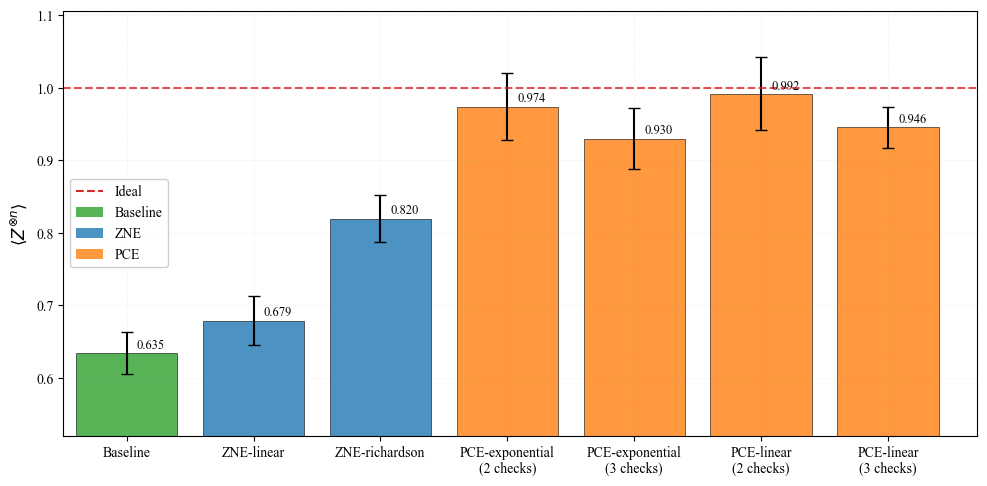


Figure saved as expectation_values_4q_25d.pdf and expectation_values_4q_25d.png

ERROR BAR INTERPRETATION:
• Error bars show ±1 standard deviation (SD)
• This is NOT a 95% confidence interval
• ±1 SD captures ~68% of the data (if normally distributed)
• ±2 SD would capture ~95% of the data
• Current error bars show the variability/spread of results

For 95% confidence intervals, multiply error bars by ~1.96
Or use standard error: SD/√n for confidence in the mean

Ideal: 1.000000, Baseline: 0.634536

Method performance (mean ± std dev):
  ZNE-linear:
    Mean: 0.678925 ± 0.034154 (n=5 circuits)
    Error reduction: 12.1%
  ZNE-richardson:
    Mean: 0.819592 ± 0.032011 (n=5 circuits)
    Error reduction: 50.6%
  PCE-exponential (2 checks):
    Mean: 0.973775 ± 0.046302 (n=5 circuits)
    Error reduction: 92.8%
  PCE-exponential (3 checks):
    Mean: 0.929920 ± 0.041467 (n=5 circuits)
    Error reduction: 80.8%
  PCE-linear (2 checks):
    Mean: 0.991656 ± 0.050090 (n=5 circuits)
    Err

In [7]:
# Set publication-quality parameters
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
rcParams['font.size'] = 11
rcParams['axes.labelsize'] = 25
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 300

def load_results(filename):
    """Load incrementally saved results from JSONL file."""
    results = []
    with open(filename, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    return results

def collect_method_values(results):
    """Collect all values for each method from results."""
    method_values = {
        'ideal': [r['ideal'] for r in results],
        'baseline': [r['baseline'] for r in results]
    }

    # PCE results
    for result in results:
        for key, value in result['pce'].items():
            if value is not None:
                if key not in method_values:
                    method_values[key] = []
                method_values[key].append(value)

    # ZNE results
    for result in results:
        for zne_result in result['zne']:
            key = f"zne_{zne_result['zne_method']}"
            if key not in method_values:
                method_values[key] = []
            method_values[key].append(zne_result['expectation'])

    return method_values

def get_clean_label(method_name):
    """Convert method name to clean label for plotting with line breaks."""
    if method_name == 'baseline':
        return 'Baseline'

    # Handle PCE methods - extract extrapolation and check count
    if method_name.startswith('pce_'):
        parts = method_name.split('_')
        if len(parts) >= 3:
            extrapolation = parts[1]  # 'linear' or 'exponential'
            check_info = parts[2]      # e.g., '2pts' or '3pts'

            # Extract number from check_info (e.g., '2pts' -> '2')
            num_checks = ''.join(filter(str.isdigit, check_info))

            # Create two-line label with full method name
            if extrapolation == 'linear':
                return f'PCE-linear\n({num_checks} checks)'
            elif extrapolation == 'exponential':
                return f'PCE-exponential\n({num_checks} checks)'
            else:
                return f'PCE-{extrapolation}\n({num_checks} checks)'
        return method_name

    # Handle ZNE methods
    if method_name.startswith('zne_'):
        zne_type = method_name.replace('zne_', '')
        if 'linear' in zne_type:
            return 'ZNE-linear'
        elif 'richardson' in zne_type:
            return 'ZNE-richardson'
        elif 'exponential' in zne_type:
            return 'ZNE-exponential'
        elif 'polynomial' in zne_type:
            return 'ZNE-polynomial'
        return f'ZNE-{zne_type}'

    return method_name

def get_method_color(method_name):
    """Get standard scientific color scheme for each method type."""
    if method_name == 'baseline':
        return 'tab:green'
    elif method_name.startswith('pce_'):
        return 'tab:orange'
    elif method_name.startswith('zne_'):
        return 'tab:blue'
    else:
        return '#808080'  # Gray for other

def plot_expectation_values(results_file, num_qubits, circ_depth):
    """Create publication-ready plot of expectation values."""

    # Load results
    try:
        results = load_results(results_file)
        print(f"Loaded {len(results)} circuit results")
    except FileNotFoundError:
        print(f"Results file {results_file} not found")
        return

    if not results:
        print("No results to visualize.")
        return

    # Collect method values
    method_values = collect_method_values(results)

    # Calculate reference values
    ideal_mean = np.mean(method_values['ideal'])
    baseline_mean = np.mean(method_values['baseline'])

    # Build ordered list of methods to plot: baseline, ZNE, then PCE
    methods_to_plot = ['baseline']
    zne_methods = sorted([k for k in method_values.keys() if k.startswith('zne_') and method_values[k]])
    pce_methods = sorted([k for k in method_values.keys() if k.startswith('pce_') and method_values[k]])
    methods_to_plot.extend(zne_methods)
    methods_to_plot.extend(pce_methods)

    # Calculate statistics
    # NOTE: Error bars show ±1 standard deviation (not confidence interval)
    # This represents ~68% of the data if normally distributed
    means = [np.mean(method_values[m]) for m in methods_to_plot]
    stds = [np.std(method_values[m]) if len(method_values[m]) > 1 else 0 for m in methods_to_plot]
    n_samples = [len(method_values[m]) for m in methods_to_plot]

    # Get labels and colors
    labels = [get_clean_label(m) for m in methods_to_plot]
    colors = [get_method_color(m) for m in methods_to_plot]

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 5))

    print(stds)

    # Bar plot with standard deviation error bars
    bars = ax.bar(range(len(methods_to_plot)), means, yerr=stds,
                capsize=4, alpha=0.8, color=colors,
                edgecolor='black', linewidth=0.5)

    # Add value labels on top of bars but shifted right to avoid error bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        # Position text on top of bar, shifted to the right
        x_offset = 0.08  # Shift right to avoid error bar
        x_pos = bar.get_x() + bar.get_width()/2 + x_offset
        y_pos = bar.get_height() + 0.002 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # Just above bar

        ax.text(x_pos, y_pos, f'{mean:.3f}',
                ha='left', va='bottom',  # Left-aligned from offset position
                fontsize=9, fontweight='normal')

    # Reference lines
    ax.axhline(y=ideal_mean, color='tab:red', linestyle='--',
                linewidth=1.5, alpha=0.8)

    # Formatting
    ax.set_xticks(range(len(methods_to_plot)))
    ax.set_xticklabels(labels, rotation=0, ha='center', va='top')
    ax.set_ylabel(r'$\langle Z^{\otimes n} \rangle$', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_xlim(-0.5, len(methods_to_plot)-0.5 + 0.2)  # Small extra space for labels

    # Adjust y-axis to accommodate value labels and error bars
    y_range = max(means) - min(means)
    y_margin = 0.18 * y_range
    ax.set_ylim(min(means) - max(stds) - y_margin,
                max(means) + max(stds) + y_margin)

    # Adjust bottom margin to accommodate two-line labels
    plt.subplots_adjust(bottom=0.15)

    # Legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='tab:red', linestyle='--', linewidth=1.5, label='Ideal'),
        Patch(facecolor='tab:green', alpha=0.8, label='Baseline'),
        Patch(facecolor='tab:blue', alpha=0.8, label='ZNE'),
        Patch(facecolor='tab:orange', alpha=0.8, label='PCE')
    ]
    ax.legend(handles=legend_elements, loc='best', framealpha=0.95)

    plt.tight_layout()

    # Save
    output_base = f"expectation_values_{num_qubits}q_{circ_depth}d"
    plt.savefig(f"{output_base}.pdf", bbox_inches='tight', pad_inches=0.1)
    plt.savefig(f"{output_base}.png", bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

    print(f"\nFigure saved as {output_base}.pdf and {output_base}.png")

    # Explain error bars clearly
    print("\n" + "="*60)
    print("ERROR BAR INTERPRETATION:")
    print("="*60)
    print("• Error bars show ±1 standard deviation (SD)")
    print("• This is NOT a 95% confidence interval")
    print("• ±1 SD captures ~68% of the data (if normally distributed)")
    print("• ±2 SD would capture ~95% of the data")
    print("• Current error bars show the variability/spread of results")
    print("\nFor 95% confidence intervals, multiply error bars by ~1.96")
    print("Or use standard error: SD/√n for confidence in the mean")
    print("="*60)

    # Print detailed summary
    print(f"\nIdeal: {ideal_mean:.6f}, Baseline: {baseline_mean:.6f}")
    print("\nMethod performance (mean ± std dev):")
    for label, mean_val, std_val, n in zip(labels[1:], means[1:], stds[1:], n_samples[1:]):
        clean_print_label = label.replace('\n', ' ')
        error = abs(mean_val - ideal_mean)
        improvement = (1 - error/abs(baseline_mean - ideal_mean)) * 100
        print(f"  {clean_print_label}:")
        print(f"    Mean: {mean_val:.6f} ± {std_val:.6f} (n={n} circuits)")
        print(f"    Error reduction: {improvement:.1f}%")

# Main execution
plot_expectation_values(results_file, num_qubits, circ_depth)



Loaded 5 circuit results


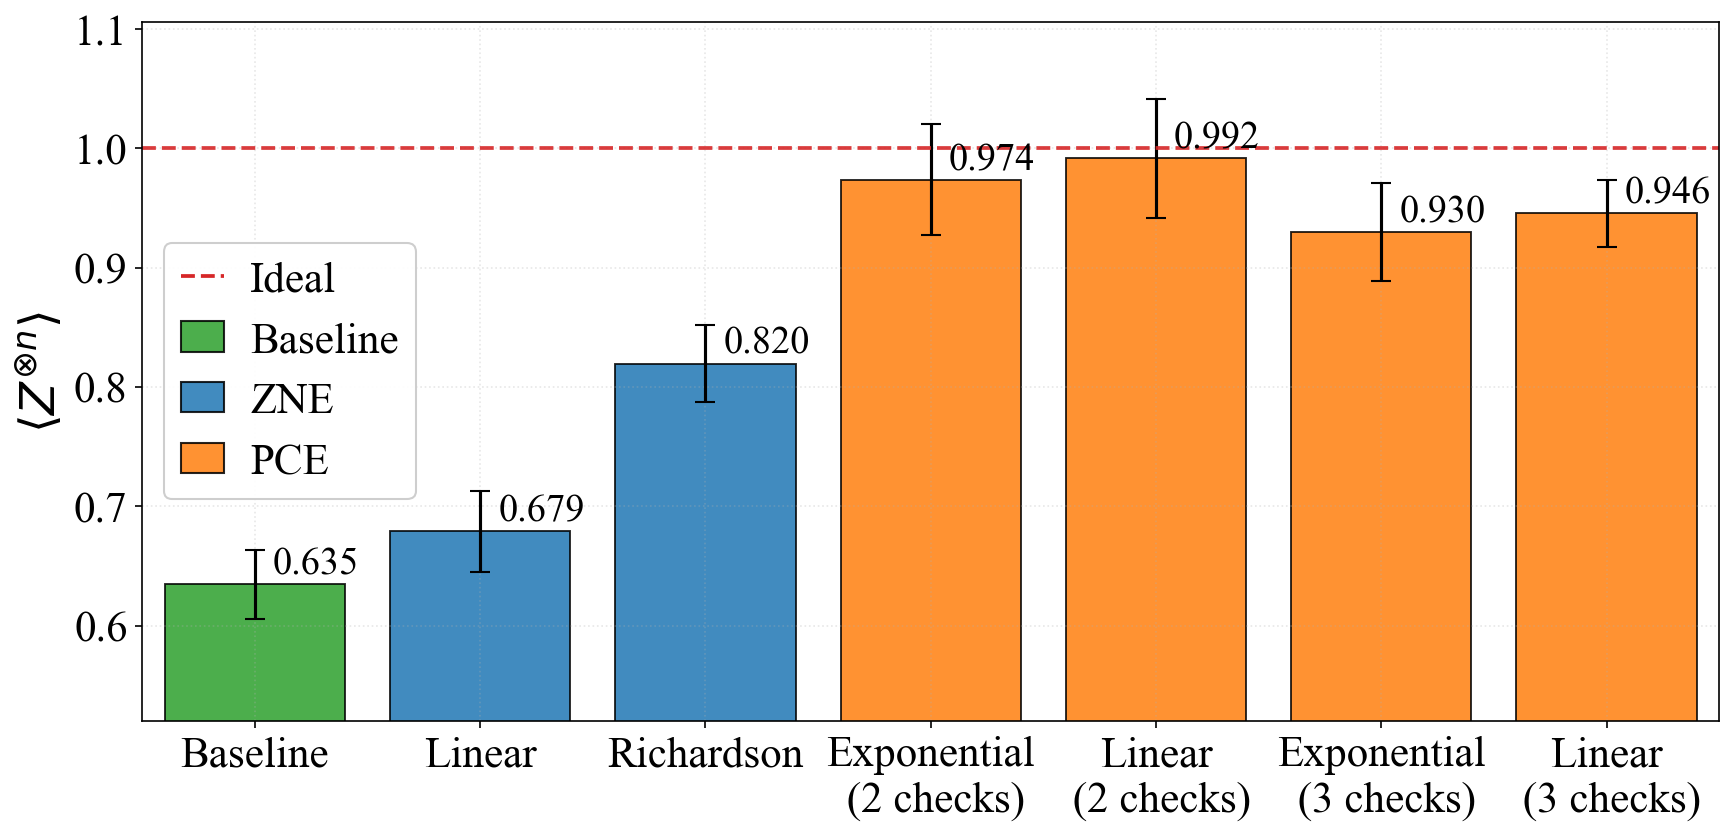


Figure saved as expectation_values_4q_25d.pdf and expectation_values_4q_25d.png

Ideal: 1.000000, Baseline: 0.634536

Method performance (mean ± std dev):
  Linear:
    Mean: 0.678925 ± 0.034154 (n=5 circuits)
    Error reduction: 12.1%
  Richardson:
    Mean: 0.819592 ± 0.032011 (n=5 circuits)
    Error reduction: 50.6%
  Exponential  (2 checks):
    Mean: 0.973775 ± 0.046302 (n=5 circuits)
    Error reduction: 92.8%
  Linear  (2 checks):
    Mean: 0.991656 ± 0.050090 (n=5 circuits)
    Error reduction: 97.7%
  Exponential  (3 checks):
    Mean: 0.929920 ± 0.041467 (n=5 circuits)
    Error reduction: 80.8%
  Linear  (3 checks):
    Mean: 0.945542 ± 0.028023 (n=5 circuits)
    Error reduction: 85.1%


In [46]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ── Publication parameters (1.15× original font sizes) ────────────────
rcParams['font.family']    = 'serif'
rcParams['font.serif']     = ['Times New Roman', 'DejaVu Serif']

rcParams['font.size']      = 20.7    # was 18
rcParams['axes.titlesize'] = 29.9    # was 26
rcParams['axes.labelsize'] = 29.9    # was 26
rcParams['xtick.labelsize']= 20.7    # was 18
rcParams['ytick.labelsize']= 28.75   # was 25
rcParams['legend.fontsize']= 20.7    # was 18
rcParams['figure.dpi']     = 150
rcParams['savefig.dpi']    = 300
rcParams['hatch.linewidth']= 1.2     # crisper hatches

def load_results(filename):
    """Load incrementally saved results from JSONL file."""
    results = []
    with open(filename, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    return results

def collect_method_values(results):
    """Collect all values for each method from results."""
    method_values = {
        'ideal': [r['ideal'] for r in results],
        'baseline': [r['baseline'] for r in results]
    }

    # PCE results
    for result in results:
        for key, value in result['pce'].items():
            if value is not None:
                method_values.setdefault(key, []).append(value)

    # ZNE results
    for result in results:
        for zne_result in result['zne']:
            key = f"zne_{zne_result['zne_method']}"
            method_values.setdefault(key, []).append(zne_result['expectation'])

    return method_values

def get_clean_label(method_name):
    """Convert method name to clean label for plotting with line breaks."""
    if method_name == 'baseline':
        return 'Baseline'

    if method_name.startswith('pce_'):
        parts = method_name.split('_')
        if len(parts) >= 3:
            extrap = parts[1]
            num_checks = ''.join(filter(str.isdigit, parts[2]))
            if extrap == 'linear':
                return f'Linear\n ({num_checks} checks)'
            elif extrap == 'exponential':
                return f'Exponential\n ({num_checks} checks)'
            else:
                return f'PCE-{extrap}\n{num_checks} checks'
        return method_name

    if method_name.startswith('zne_'):
        z = method_name.replace('zne_', '')
        if 'linear' in z:       return 'Linear'
        if 'richardson' in z:   return 'Richardson'
        if 'exponential' in z:  return 'Exponential'
        if 'polynomial' in z:   return 'Polynomial'
        return f'ZNE-{z}'

    return method_name

def get_method_color(method_name):
    """Get standard scientific color scheme for each method type."""
    if method_name == 'baseline':     return 'tab:green'
    if method_name.startswith('pce_'):return 'tab:orange'
    if method_name.startswith('zne_'):return 'tab:blue'
    return '#808080'  # Gray

def get_method_hatch(method_name):
    """Hatch pattern per category for colorblind accessibility."""
    if method_name == 'baseline':      return '.'  # diagonal
    if method_name.startswith('zne_'): return '/'   # cross
    if method_name.startswith('pce_'): return 'x'   # dots
    return ''  # default: no hatch

def plot_expectation_values(results_file, num_qubits, circ_depth):
    """Create publication-ready plot of expectation values."""
    try:
        results = load_results(results_file)
        print(f"Loaded {len(results)} circuit results")
    except FileNotFoundError:
        print(f"Results file {results_file} not found")
        return

    if not results:
        print("No results to visualize.")
        return

    method_values = collect_method_values(results)

    ideal_mean    = np.mean(method_values['ideal'])
    baseline_mean = np.mean(method_values['baseline'])

    methods_to_plot = ['baseline']

    # ---- ZNE methods (unchanged sorting) ----
    zne_methods = sorted([k for k in method_values if k.startswith('zne_') and method_values[k]])

    # ---- PCE methods: enforce order E2, L2, E3, L3 ----
    pce_all = [k for k in method_values if k.startswith('pce_') and method_values[k]]
    desired = [('exponential', 2), ('linear', 2), ('exponential', 3), ('linear', 3)]
    pce_ordered = []

    for ex, n in desired:
        for k in pce_all:
            parts = k.split('_')
            if len(parts) >= 3:
                extrap = parts[1]
                digits = ''.join(filter(str.isdigit, parts[2]))
                checks = int(digits) if digits else None
                if extrap == ex and checks == n and k not in pce_ordered:
                    pce_ordered.append(k)
                    break
    # Append any remaining pce keys not matched (keeps original presence)
    for k in pce_all:
        if k not in pce_ordered:
            pce_ordered.append(k)

    methods_to_plot.extend(zne_methods + pce_ordered)

    means = [np.mean(method_values[m]) for m in methods_to_plot]
    stds  = [np.std(method_values[m]) if len(method_values[m]) > 1 else 0 for m in methods_to_plot]
    n_samples = [len(method_values[m]) for m in methods_to_plot]

    labels  = [get_clean_label(m) for m in methods_to_plot]
    colors  = [get_method_color(m) for m in methods_to_plot]
    hatches = [get_method_hatch(m) for m in methods_to_plot]

    fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.bar(
        range(len(methods_to_plot)), means, yerr=stds,
        capsize=5, alpha=0.85, color=colors,
        edgecolor='black', linewidth=0.9
    )

    # Apply hatches to each bar
    # for bar, hatch in zip(bars, hatches):
    #     bar.set_hatch(hatch)

    # Bar value labels
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        x_offset = 0.08  # Shift right to avoid error bar
        x_pos = bar.get_x() + bar.get_width()/2 + x_offset
        y_pos = bar.get_height() + 0.002 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        ax.text(x_pos, y_pos, f'{mean:.3f}',
                ha='left', va='bottom',
                fontsize=18.4, fontweight='normal')  # was 16 × 1.15

    # Reference line
    ax.axhline(y=ideal_mean, color='tab:red', linestyle='--', linewidth=1.8, alpha=0.9, label='Ideal')

    # Formatting
    ax.set_xticks(range(len(methods_to_plot)))
    ax.set_xticklabels(labels, rotation=0, ha='center', va='top')
    ax.set_ylabel(r'$\langle Z^{\otimes n} \rangle$', fontsize=23.0)  # was 20 × 1.15
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    ax.set_xlim(-0.5, len(methods_to_plot) - 0.5)

    # Y-lims with margin
    y_range  = max(means) - min(means)
    y_margin = 0.18 * y_range if y_range > 0 else 0.05
    ax.set_ylim(min(means) - max(stds) - y_margin,
                max(means) + max(stds) + y_margin)

    # Larger tick labels (explicit)
    ax.tick_params(axis='both', which='major', labelsize=20.7)  # was 18 × 1.15

    # Legend with matching hatches
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='tab:red', linestyle='--', linewidth=1.8, label='Ideal'),
        Patch(facecolor='tab:green',  edgecolor='black', alpha=0.85, label='Baseline'),
        Patch(facecolor='tab:blue',   edgecolor='black', alpha=0.85,  label='ZNE'),
        Patch(facecolor='tab:orange', edgecolor='black', alpha=0.85,  label='PCE')
    ]
    ax.legend(
        handles=legend_elements,
        loc='best',
        framealpha=0.95,
        fontsize=20.7,           # was 18 × 1.15
        borderpad=0.4,
        handlelength=1.0,
        handletextpad=0.6,
        labelspacing=0.5
    )

    # Bottom margin for two-line x labels
    plt.subplots_adjust(bottom=0.20)
    plt.tight_layout()

    # Save
    output_base = f"expectation_values_{num_qubits}q_{circ_depth}d"
    plt.savefig(f"{output_base}.pdf", bbox_inches='tight', pad_inches=0.1)
    plt.savefig(f"{output_base}.png", bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

    print(f"\nFigure saved as {output_base}.pdf and {output_base}.png")
    print(f"\nIdeal: {ideal_mean:.6f}, Baseline: {baseline_mean:.6f}")
    print("\nMethod performance (mean ± std dev):")
    for label, mean_val, std_val, n in zip(labels[1:], means[1:], stds[1:], n_samples[1:]):
        clean_label = label.replace('\n', ' ')
        error = abs(mean_val - ideal_mean)
        improvement = (1 - error/abs(baseline_mean - ideal_mean)) * 100 if baseline_mean != ideal_mean else 0.0
        print(f"  {clean_label}:")
        print(f"    Mean: {mean_val:.6f} ± {std_val:.6f} (n={n} circuits)")
        print(f"    Error reduction: {improvement:.1f}%")

# Main execution
plot_expectation_values(results_file, num_qubits, circ_depth)



